In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import joblib

In [ ]:
df = pd.read_csv('/content/PHL_HWC.csv')
df.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,-120.0,413.0,0,Mass,...,NaN,0.214133,0,0,NaN,0,NaN,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,-3.6,4.4,0,Mass,...,2.097783,0.316980,0,0,Hot,0,0.272032,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,NaN,NaN,0,M-R relationship,...,1.756317,0.459559,0,0,Hot,0,0.254763,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,NaN,NaN,0,M-R relationship,...,0.568374,0.443760,0,0,Hot,0,0.193906,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,NaN,NaN,0,M-R relationship,...,0.768502,0.386150,0,0,Hot,0,0.276721,Lyra,Lyr,Lyre


In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


(5599, 118)

In [ ]:
# Factors on which Radiation levels depend => S_TEMPERATURE, S_METALLICITY, S_LOG_LUM, S_AGE, S_DISTANCE, P_RADIUS, P_MASS
depending_factors = ['S_TEMPERATURE', 'S_METALLICITY', 'S_LOG_LUM', 'S_AGE', 'S_DISTANCE', 'P_RADIUS', 'P_MASS']
df[depending_factors].isnull().sum()

,0
S_TEMPERATURE,219
S_METALLICITY,433
S_LOG_LUM,235
S_AGE,1207
S_DISTANCE,21
P_RADIUS,7
P_MASS,7


In [ ]:
df.dropna(subset=['P_RADIUS' and 'P_MASS' and 'S_DISTANCE'], inplace=True)
df.shape

(5578, 118)

In [ ]:
df[depending_factors].isnull().sum()

,0
S_TEMPERATURE,215
S_METALLICITY,426
S_LOG_LUM,230
S_AGE,1200
S_DISTANCE,0
P_RADIUS,7
P_MASS,7


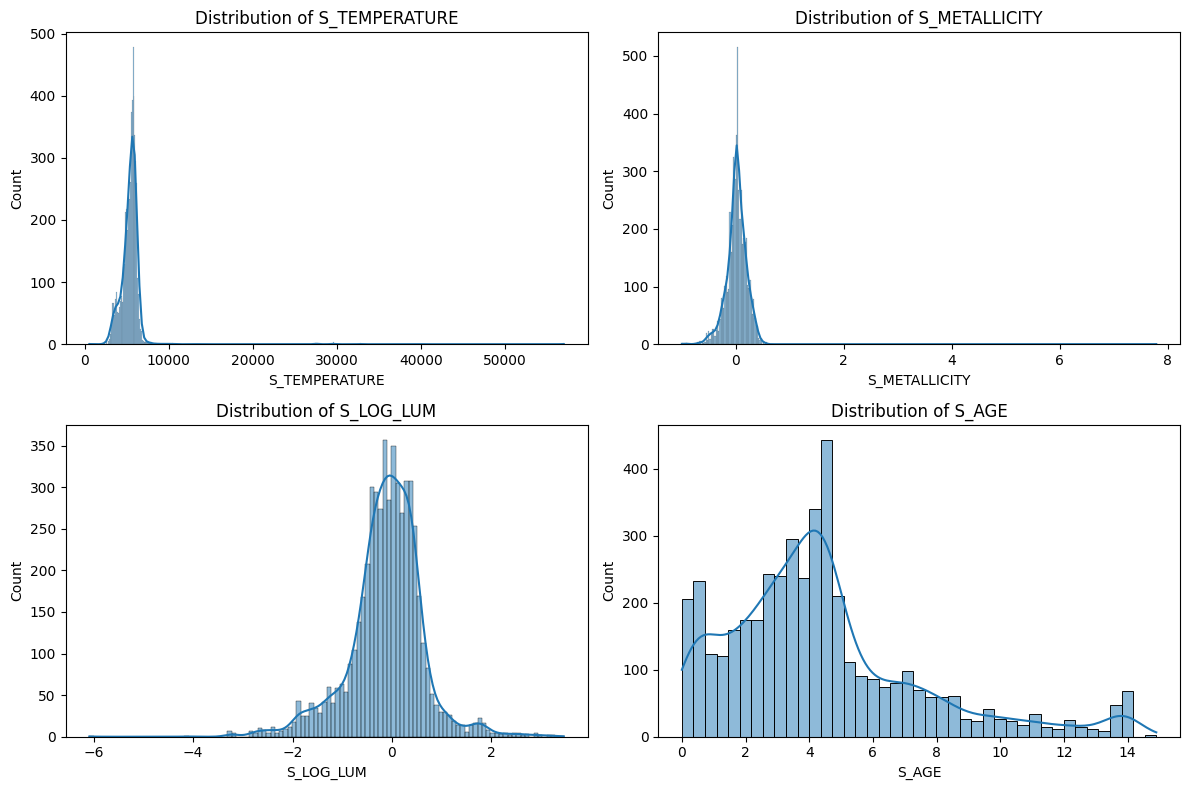

In [ ]:
# Visualizing the missing data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['S_TEMPERATURE'], kde=True, ax=axes[0, 0]).set(title='Distribution of S_TEMPERATURE')
sns.histplot(df['S_METALLICITY'], kde=True, ax=axes[0, 1]).set(title='Distribution of S_METALLICITY')
sns.histplot(df['S_LOG_LUM'], kde=True, ax=axes[1, 0]).set(title='Distribution of S_LOG_LUM')
sns.histplot(df['S_AGE'], kde=True, ax=axes[1, 1]).set(title='Distribution of S_AGE')
plt.tight_layout()
plt.show()

In [ ]:
# Median imputation on S_TEMP, S_LOG_LUM and S_METAL
df['S_TEMPERATURE'].fillna(df['S_TEMPERATURE'].median(), inplace=True)
df['S_METALLICITY'].fillna(df['S_METALLICITY'].median(), inplace=True)
df['S_LOG_LUM'].fillna(df['S_LOG_LUM'].mean(), inplace=True)

<ipython-input-65-13f38825245c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['S_TEMPERATURE'].fillna(df['S_TEMPERATURE'].median(), inplace=True)
<ipython-input-65-13f38825245c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [ ]:
df[depending_factors].isnull().sum()

,0
S_TEMPERATURE,0
S_METALLICITY,0
S_LOG_LUM,0
S_AGE,1200
S_DISTANCE,0
P_RADIUS,7
P_MASS,7


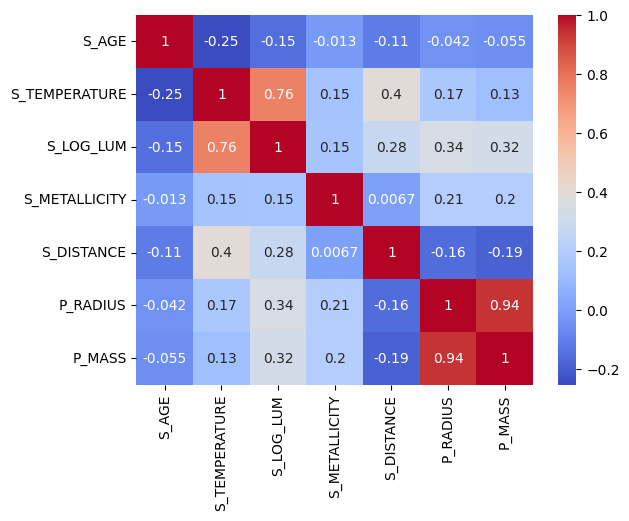

In [ ]:
# As S_AGE contains a higher number of missing values we find its correlation matrix
correlation_matrix = df[['S_AGE', 'S_TEMPERATURE', 'S_LOG_LUM', 'S_METALLICITY', 'S_DISTANCE', 'P_RADIUS', 'P_MASS']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# As no relation exists between any of the radiation specific features we use KNN imputation which takes up nearest K values to impute the values
knn_imputer = KNNImputer(n_neighbors=5)
df[depending_factors] = knn_imputer.fit_transform(df[depending_factors])

In [ ]:
df[depending_factors].isnull().sum()

,0
S_TEMPERATURE,0
S_METALLICITY,0
S_LOG_LUM,0
S_AGE,0
S_DISTANCE,0
P_RADIUS,0
P_MASS,0


In [ ]:
new_csv_file_cols = df[['S_TEMPERATURE', 'S_METALLICITY', 'S_LOG_LUM', 'S_AGE', 'S_DISTANCE', 'P_RADIUS', 'P_MASS']]
new_csv_file_cols.to_csv('radiation_of_planet.csv', index=False)

In [ ]:
radiation_df = pd.read_csv('/content/radiation_of_planet.csv')
radiation_df.head()

,S_TEMPERATURE,S_METALLICITY,S_LOG_LUM,S_AGE,S_DISTANCE,P_RADIUS,P_MASS
0,5779.0,0.02,-0.089,0.400,1144.8600,2.90,16.60
1,5698.0,0.03,0.040,4.680,1073.7600,2.11,5.10
2,5060.0,0.28,-0.524,3.972,402.9150,3.52,12.20
3,5240.0,-0.04,-0.372,2.090,367.0000,2.07,4.94
4,4227.0,-0.10,-0.889,6.700,73.5977,2.76,13.20


In [ ]:
X = radiation_df
print(X.head())

   S_TEMPERATURE  S_METALLICITY  S_LOG_LUM  S_AGE  S_DISTANCE  P_RADIUS  \
0         5779.0           0.02     -0.089  0.400   1144.8600      2.90   
1         5698.0           0.03      0.040  4.680   1073.7600      2.11   
2         5060.0           0.28     -0.524  3.972    402.9150      3.52   
3         5240.0          -0.04     -0.372  2.090    367.0000      2.07   
4         4227.0          -0.10     -0.889  6.700     73.5977      2.76   

   P_MASS  
0   16.60  
1    5.10  
2   12.20  
3    4.94  
4   13.20  


In [ ]:
# Standardizing the values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(pd.DataFrame(X_scaled))

             0         1             2         3         4         5         6
0     0.198802  0.029123  3.447792e-02 -1.408917  0.405176 -0.528157 -0.179127
1     0.151983  0.077834  2.086007e-01  0.084941  0.340906 -0.676594 -0.183980
2    -0.216790  1.295618 -5.526803e-01 -0.162174 -0.265494 -0.411662 -0.180984
3    -0.112747 -0.263145 -3.475124e-01 -0.819052 -0.297959 -0.684110 -0.184048
4    -0.698274 -0.555413 -1.045353e+00  0.789985 -0.563175 -0.554462 -0.180562
...        ...       ...           ...       ...       ...       ...       ...
5573  0.153717 -0.945104  8.416517e-01  1.313533 -0.583957  1.444742  0.059343
5574  0.246199  0.223968  6.850762e-01  1.208824 -0.599631 -0.605194 -0.178873
5575  0.036380  0.808504 -1.652908e-01 -0.850465  0.196693 -0.340262 -0.181364
5576 -0.100609  0.126546 -2.098339e-01  1.173921 -0.586956 -0.712294 -0.184305
5577  0.069905  0.029123  1.123925e-16  0.403258  4.857182  1.463531  0.048209

[5578 rows x 7 columns]


In [ ]:
print("Mean of each feature after scaling:", X_scaled.mean(axis=0))
print("Standard deviation of each feature after scaling:", X_scaled.std(axis=0))

Mean of each feature after scaling: [-4.96793953e-17  1.27383065e-17  0.00000000e+00 -1.27383065e-18
 -9.17158067e-17  7.13345163e-17 -8.91681454e-18]
Standard deviation of each feature after scaling: [1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Applying K Means for clustering using unsupervised learning
kmeans = KMeans(n_clusters=3, random_state=42)
radiation_df.loc[X.index, 'Radiation_Level'] = kmeans.fit_predict(X_scaled)

In [ ]:
# Analyze and plot cluster centers to interpret
centers = kmeans.cluster_centers_

# Create a DataFrame for the cluster centers to scale them back
centers_scaled = scaler.inverse_transform(centers)
print(pd.DataFrame(centers_scaled))

             0         1         2         3            4          5  \
0  5267.346192 -0.009139 -0.311354  3.727577   609.413116   2.530665   
1  5297.999930  0.009725 -0.201021  9.347092  1839.823895   6.270615   
2  5925.035493  0.074131  0.422052  3.674272   324.502149  13.371475   

             6  
0    28.247168  
1   258.122158  
2  1567.217099  


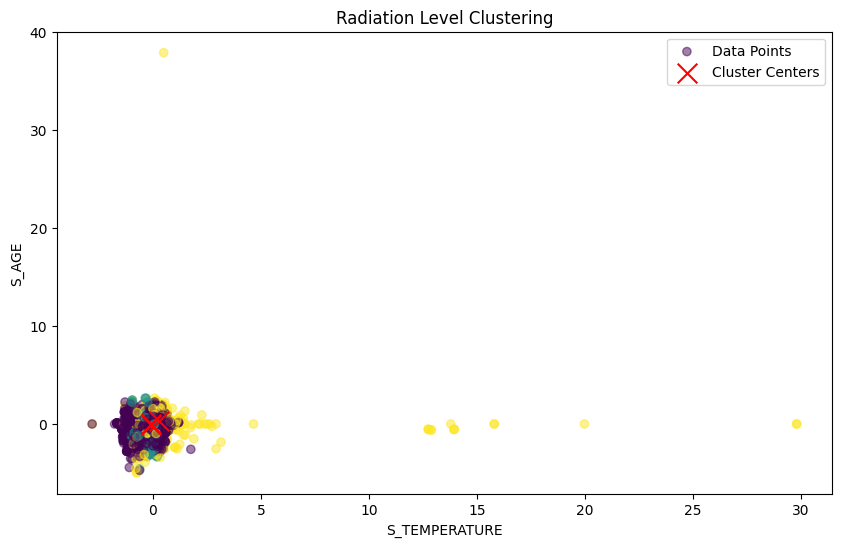

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=radiation_df.loc[X.index, 'Radiation_Level'], cmap='viridis', alpha=0.5, label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.title("Radiation Level Clustering")
plt.xlabel(depending_factors[0])
plt.ylabel(depending_factors[3])
plt.legend()
plt.show()

In [ ]:
data = [[5574.441176,  0.016176, -0.128879,  3.831868,  6040.882353,  11.217000,	1019.623201]]
X_scaled_data = scaler.transform(data)
print(X_scaled_data)

[[ 0.08056396  0.01049567 -0.01935031 -0.21108468  4.83086144  1.03456683
   0.24419924]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
print(kmeans.predict(X_scaled_data))

[1]


In [ ]:
# Silhoutte Score
silhouette_avg = silhouette_score(X_scaled, radiation_df['Radiation_Level'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.3082930588668206


In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=1)  # Adjust based on your needs
X_pca = pca.fit_transform(X_scaled)

# Re-apply Agglomerative Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
radiation_df.loc[X.index, 'Radiation_Level'] = kmeans.fit_predict(X_pca)

# Check Silhouette Score again
silhouette = silhouette_score(X_pca, radiation_df['Radiation_Level'])
print("Silhouette Score after PCA:", silhouette)

Silhouette Score after PCA: 0.5334502863838687


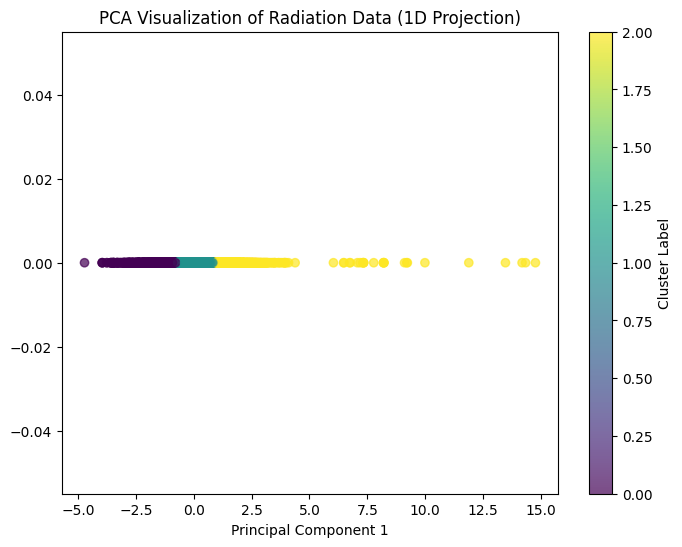

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]), c=radiation_df['Radiation_Level'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster Label")
plt.xlabel("Principal Component 1")
plt.title("PCA Visualization of Radiation Data (1D Projection)")
plt.show()

# Gaussian Mixture

In [ ]:
# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
radiation_df['Radiation_Level'] = gmm.fit_predict(X_scaled)
print(radiation_df[['Radiation_Level']].tail())

      Radiation_Level
5573                1
5574                0
5575                0
5576                0
5577                1


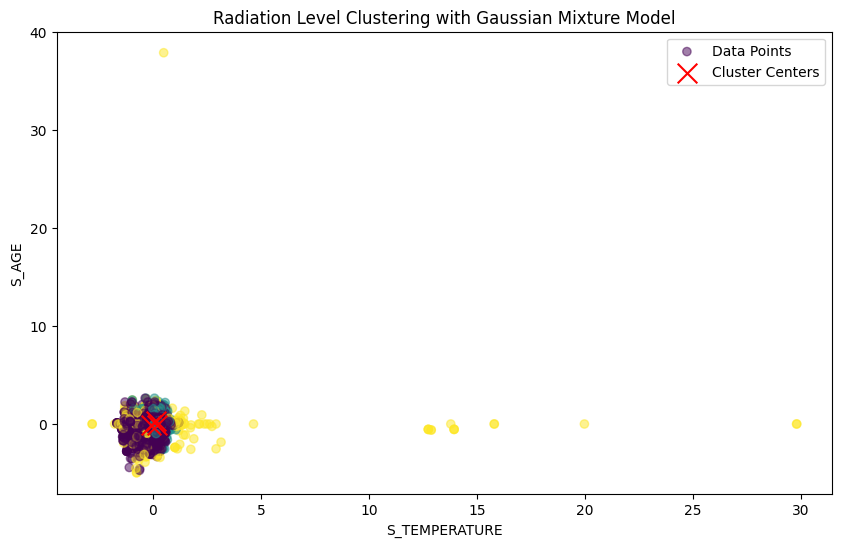

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=radiation_df['Radiation_Level'], cmap='viridis', alpha=0.5, label='Data Points')
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
plt.title("Radiation Level Clustering with Gaussian Mixture Model")
plt.xlabel(depending_factors[0])
plt.ylabel(depending_factors[3])
plt.legend()
plt.show()

In [ ]:
# Calculate Silhouette Score
silhouette = silhouette_score(X_scaled, radiation_df['Radiation_Level'])
print("Silhouette Score:", silhouette)

Silhouette Score: 0.2416880148441626


In [ ]:
# Calculate AIC and BIC
aic = gmm.aic(X_scaled)
bic = gmm.bic(X_scaled)

print("AIC:", aic)
print("BIC:", bic)

AIC: 24896.42080008793
BIC: 25605.465455883987


# Agglomerative Clustering

In [ ]:
# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
radiation_df['Radiation_Level'] = agg_clustering.fit_predict(X_scaled)

In [ ]:
silhouette = silhouette_score(X_scaled, radiation_df['Radiation_Level'])
print("Silhouette Score:", silhouette)

Silhouette Score: 0.3104632731695946


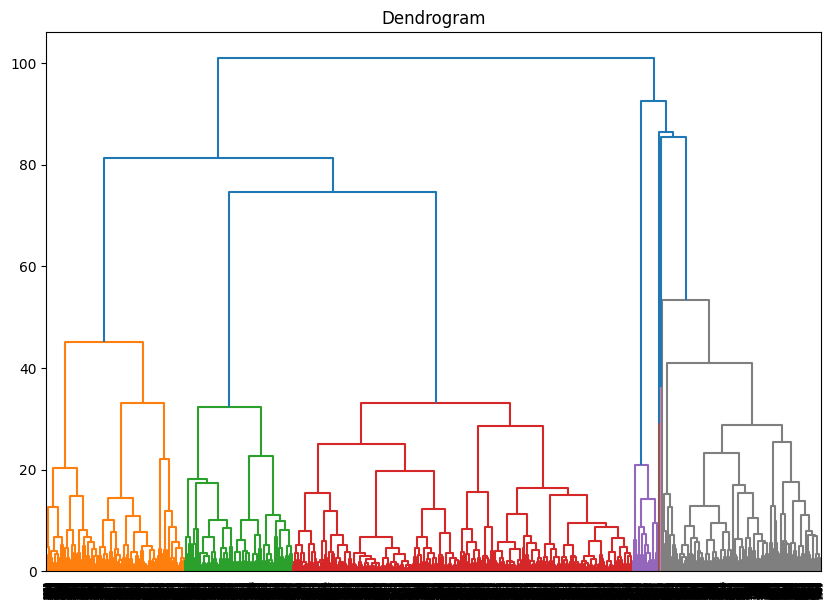

In [ ]:
import scipy.cluster.hierarchy as shc

# Plot dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=2)  # Adjust based on your needs
X_pca = pca.fit_transform(X_scaled)

# Re-apply Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)
radiation_df['Radiation_Level'] = agglomerative.fit_predict(X_pca)

# Check Silhouette Score again
silhouette = silhouette_score(X_pca, radiation_df['Radiation_Level'])
print("Silhouette Score after PCA:", silhouette)

Silhouette Score after PCA: 0.3444063000726935


In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Re-apply Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)
radiation_df['Radiation_Level'] = agglomerative.fit_predict(X_tsne)

# Check Silhouette Score again
silhouette = silhouette_score(X_tsne, radiation_df['Radiation_Level'])
print("Silhouette Score after t-SNE:", silhouette)


Silhouette Score after t-SNE: 0.37139133


In [ ]:
# Save the scaler
joblib.dump(scaler, "scaler_model.joblib")

# Save the PCA model
joblib.dump(pca, "pca_model.joblib")

# Save the trained K-Means model
joblib.dump(kmeans, "radiation_model.joblib")

['radiation_model.joblib']

In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load models
scaler = joblib.load("scaler_model.joblib")
pca = joblib.load("pca_model.joblib")
kmeans = joblib.load("radiation_model.joblib")

# Define feature names (ensure these match your original dataset)
feature_names = ['S_TEMPERATURE', 'S_METALLICITY', 'S_LOG_LUM', 'S_AGE', 'S_DISTANCE', 'P_RADIUS', 'P_MASS']

# Create DataFrame with proper column names
new_data = pd.DataFrame([[5267.346192, -0.009139, -0.311354,  3.727577,   609.413116,   2.530665, 28.247168]],
                        columns=feature_names)

# Transform and predict
scaled_data = scaler.transform(new_data)
pca_data = pca.transform(scaled_data)
cluster = kmeans.predict(pca_data)

print("Predicted Cluster:", cluster)


Predicted Cluster: [1]


In [ ]:
# Load models
scaler = joblib.load("scaler_model.joblib")
pca = joblib.load("pca_model.joblib")
kmeans = joblib.load("radiation_model.joblib")

index = 5576  # Change this as needed
feature_columns = ['S_TEMPERATURE', 'S_METALLICITY', 'S_LOG_LUM', 'S_AGE', 'S_DISTANCE', 'P_RADIUS', 'P_MASS']

# Extract only relevant features (remove extra columns)
known_data = radiation_df.loc[index, feature_columns]

# Transform known data
known_data_scaled = scaler.transform([known_data])  # Use [ ] to keep 2D shape
known_data_pca = pca.transform(known_data_scaled)
predicted_cluster = kmeans.predict(known_data_pca)

# Compare results
true_cluster = radiation_df.loc[index, 'Radiation_Level']
print(f"Actual Cluster: {true_cluster}")
print(f"Predicted Cluster: {predicted_cluster[0]}")

Actual Cluster: 0.0
Predicted Cluster: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
print(radiation_df)

      S_TEMPERATURE  S_METALLICITY  S_LOG_LUM  S_AGE  S_DISTANCE  P_RADIUS  \
0            5779.0           0.02  -0.089000  0.400   1144.8600      2.90   
1            5698.0           0.03   0.040000  4.680   1073.7600      2.11   
2            5060.0           0.28  -0.524000  3.972    402.9150      3.52   
3            5240.0          -0.04  -0.372000  2.090    367.0000      2.07   
4            4227.0          -0.10  -0.889000  6.700     73.5977      2.76   
...             ...            ...        ...    ...         ...       ...   
5573         5701.0          -0.18   0.509000  8.200     50.6078     13.40   
5574         5861.0           0.06   0.393000  7.900     33.2673      2.49   
5575         5498.0           0.18  -0.237000  2.000    914.2210      3.90   
5576         5261.0           0.04  -0.270000  7.800     47.2899      1.92   
5577         5556.0           0.02  -0.114543  5.592   6070.0000     13.50   

         P_MASS  Radiation_Level  
0      16.60000             